In [41]:
include("models/ppl/main.jl")

In [2]:
using CairoMakie


In [3]:
struct HistoryType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Vector{Float64}}
    name::String
    info::Dict
end

In [42]:
using JSON3
using Serialization

function load_history_from_json(file_path::String)::HistoryType
    json_data = JSON3.read(file_path)
    mean_rewards = Dict{Int, Vector{Float64}}(
        parse(Int, string(k)) => Float64.(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    # info = Dict(json_data["info"])
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return HistoryType(mean_rewards, name, info)
end


load_history_from_json (generic function with 1 method)

In [43]:
simple = load_history_from_json("json/dirichlet/history/Simple.json")
medium = load_history_from_json("json/dirichlet/history/Medium.json")
full = load_history_from_json("json/dirichlet/history/None.json")
softmax = load_jld("data/mcmc/history/softmax.jld")
# simple_pp = load_jld("data/mcmc/history/simple-2.jld")


Main.History.PPHistoryRun("softmax", Main.PPModel.MCMCModel(:softmax, DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:episodes => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(56 => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trajectory => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(1 => DynamicChoiceMap(Dict{Any, Any}(:o2 => Main.SepsisTypes.NORMAL, :hr => Main.SepsisTypes.LOW, :bp => Main.SepsisTypes.HIGH, :glu => Main.SepsisTypes.LOW), Dict{Any, Any}()))))), 35 => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trajectory => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(5 => DynamicChoiceMap(Dict{Any, Any}(:o2 => Main.SepsisTypes.NORMAL, :hr => Main.SepsisTypes.HIGH, :bp => Main.SepsisTypes.HIGH, :glu => Main.SepsisTypes.LOW), Dict{Any, Any}()), 4 => DynamicChoiceMap(Dict{Any, Any}(:o2 => Main.SepsisTypes.NORMAL, :hr => Main.SepsisTypes.HIGH, :bp => Main.SepsisTypes.NORMAL, :glu => Main.SepsisTypes.LOW), Dict{Any, Any}()), 2 => DynamicChoiceMap(Dict{Any, A

In [32]:
simple_pp_ts = load_jld("data/mcmc/ts/simple-2.jld")


PPTSRun("simple-2", MCMCModel(:simple, DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:episodes => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(5 => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trajectory => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(5 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => LOW, :glu => SUPER_HIGH), Dict{Any, Any}()), 4 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => LOW, :glu => SUPER_HIGH), Dict{Any, Any}()), 6 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => HIGH, :bp => LOW, :glu => SUPER_HIGH), Dict{Any, Any}()), 2 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => LOW, :glu => HIGH), Dict{Any, Any}()), 3 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => LOW, :glu => SUPER_HIGH), Dict{Any, Any}()), 1 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => LOW, :glu => HIGH), Dict{Any, Any}()))))), 402 => DynamicChoiceMap(

In [33]:
ks = sort(collect(keys(simple_pp_ts.mean_rewards)))

13-element Vector{Int64}:
   0
   1
   2
   4
   8
  16
  32
  64
 100
 200
 300
 400
 500

In [34]:
using Gen
length(nested_view(simple_pp_ts.model.choices)[:episodes])

133

In [35]:
[simple_pp_ts.models[k].scores for k in ks]


13-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [-7.0852736655168, -6.820787951437563, -5.167663427475622, -4.991901625059308, -5.077013542498784, -5.066751298056966, -6.537626038076981, -5.497205848467663, -4.575934298971513, -4.550625964771736  …  -6.703900744003696, -7.428459049057407, -6.570423928253273, -6.915182870397078, -5.7968574167383355, -5.145516857704081, -5.907256511289935, -5.094696611521137, -5.800432694907924, -5.833235141763837]
 [-26.656933173193316, -24.398919387935692, -24.246674166378384, -23.887494326740857, -22.571358311639145, -24.00901306583397, -26.03354173492348, -23.00583646946569, -24.53951191766483, -28.149238189136533  …  -24.750768798832503, -23.543055217351235, -23.470501647127115, -28.193284696947572, -29.807087294257244, -26.486132452549427, -25.39635323908638, -26.146088672110814, -29.809119049631736, -23.92100342427784]
 [-35.72941755248686, -36.8495869430

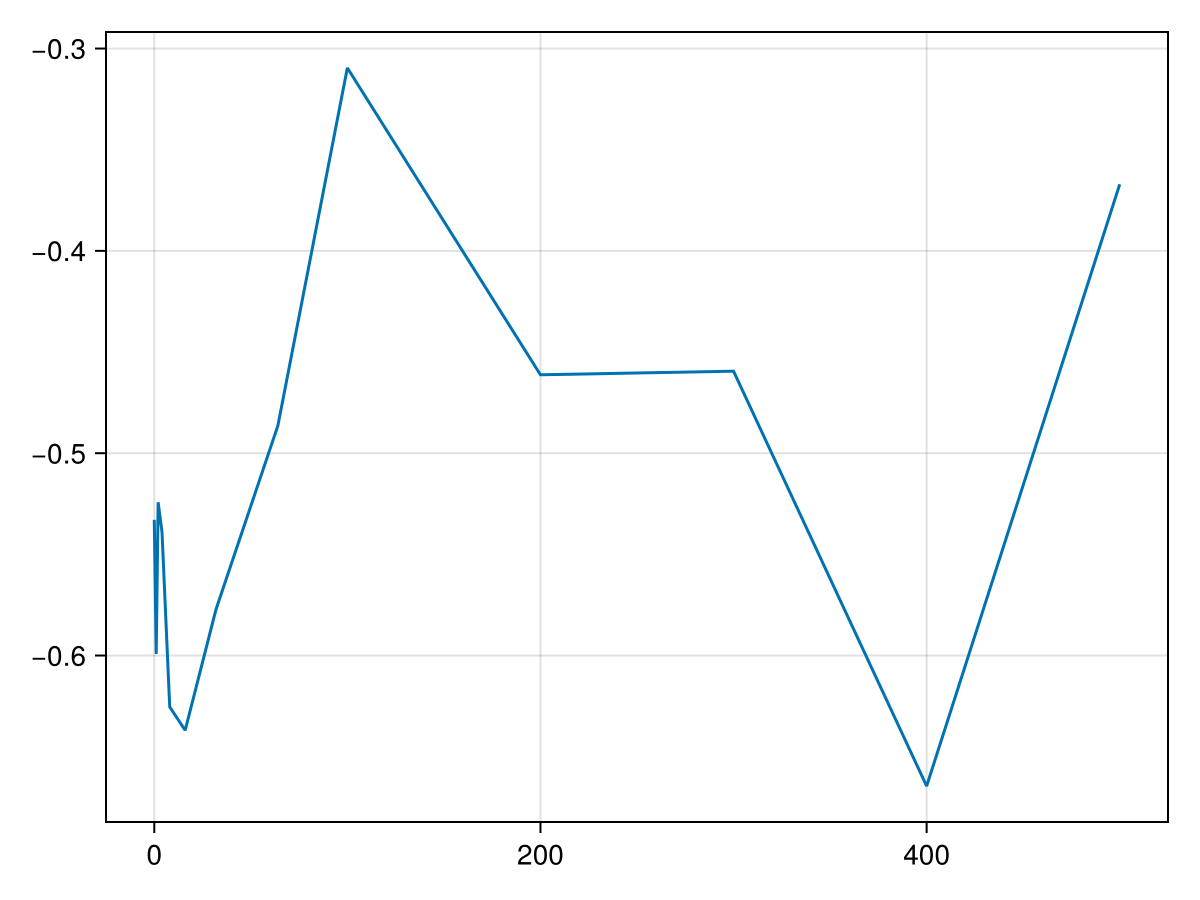

In [37]:
# [simple_pp_ts.models[k].scores for k in ks]
lines(ks, [simple_pp_ts.mean_rewards[k] for k in ks])


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


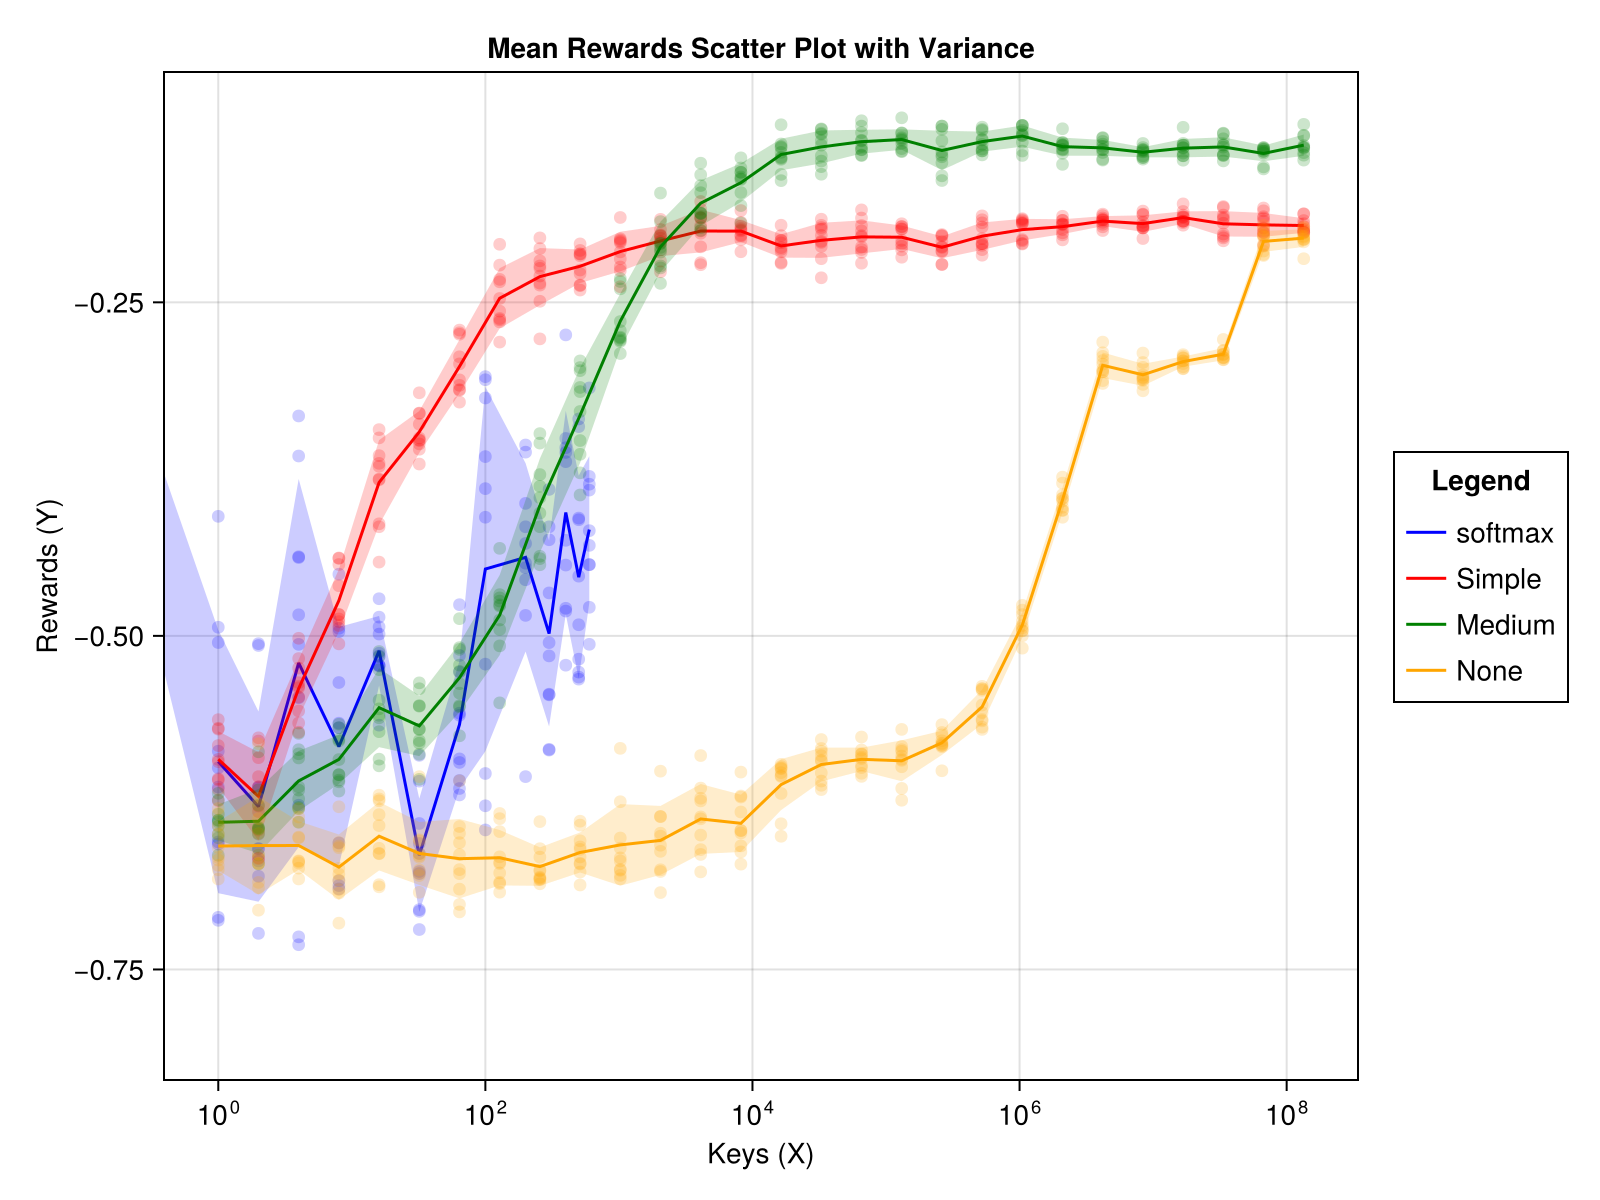

In [44]:
using CairoMakie
using Statistics

# Example: Assuming you have 5 different dictionaries stored in a list
histories = [softmax, simple, medium, full ]

# Create a figure
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xscale=log10, xlabel = "Keys (X)", ylabel = "Rewards (Y)", title = "Mean Rewards Scatter Plot with Variance")

# Define colors for each dataset
colors = [:blue, :red, :green, :orange, :purple]

# Plot each dataset
for (i, history) in enumerate(histories)
    mean_rewards = history.mean_rewards
    # Prepare data
    x_vals = sort(collect(keys(mean_rewards)))
    y_means = [mean(mean_rewards[x]) for x in x_vals]
    y_stds = [std(mean_rewards[x]) for x in x_vals]

    # Collect all (x, y) pairs for scatter
    scatter_x = []
    scatter_y = []
    for x in x_vals
        ys = mean_rewards[x]
        append!(scatter_x, fill(x, length(ys)))  # Repeat x for each y
        append!(scatter_y, ys)                  # Collect y values
    end

    # Add scatter plot for all points
    scatter!(ax, scatter_x, scatter_y, color = (colors[i], 0.2))

    # Add error band (variance) at the mean points
    band!(ax, x_vals, y_means .- y_stds, y_means .+ y_stds, color = (colors[i], 0.2), )

    # Add line for the mean points
    lines!(ax, x_vals, y_means, color = colors[i], label = history.name)
end
# xlims!(ax, 1, 1300)

# Add a legend
Legend(fig[1, 2], ax, "Legend")



# Display the plot
fig


In [55]:
struct TSType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Float64}
    name::String
    info::Dict
end

In [65]:
using JSON3
using Serialization

function load_ts_from_json(file_path::String)::TSType
    json_data = JSON3.read(file_path)
    println(json_data["policies"])
    mean_rewards = Dict{Int, Vector{Float64}}(
        parse(Int, string(k)) => Float64(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    # info = Dict(json_data["info"])
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return TSType(mean_rewards, name, info)
end

load_ts_from_json (generic function with 1 method)

In [1]:
using PyCall
sepsis_gym = pyimport("custom_sepsis")

ts = sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-0.json")

PyObject <custom_sepsis.models.dirichlet.evaluate.thompson_sampling.DirThompsonSampling object at 0x15245b9a0>